In [1]:
import numpy as np

import GPyOpt
import GPy

import sys
sys.path.append("..")

from f16lib.acas import AcasScenario, AcasShieldScenario, AcasScenarioViewer


import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

## Construct the F16 Scenario

In [2]:
def intruder_airspeed(t):
    return min(550.0 + t * 10.0, 800.0)

def air_collision_condition(ctraces):
        """ground collision premature termination condition
        """
        # get the aircraft states
        sa, sb, sc = ctraces['plant']['states'], ctraces['intruder_plant']['states'], ctraces['balloon']['states']
        if sa and sb and sc:
            # look at distance between last state
            dab =  (np.linalg.norm(np.array(sa[-1][9:11]) - np.array(sb[-1][9:11]))) 
            dac = (np.linalg.norm(np.array(sa[-1][9:11]) - np.array(sc[-1][9:11]))) 
            return dab < 500.0 or dac < 500.0
        


def get_system(states):
    """construct a scenario and system given the configuration coordinates (states)"""
    # scenario
    scen = AcasScenario(
        [-3000.0, 12000], # balloon position
        750.0, # ownship airspeed
        ((0.0, 21000.0, 1000.0),), # own waypoints
        ((*states[:2], 1000.0),), # intruder waypoints -- none for now
        intruder_velocity = intruder_airspeed
    )
    # scenario, system
    return scen, scen.create_system(
        [*states[:2], # relative position
         states[2], # relative heading
         states[3]]) # relative airspeed


def objective_function(states) -> float:
    """obj: configuration space -> real number"""
    # run simulation
    _, sys = get_system(states)
    trajs, p = sys.simulate_tspan((0.0, 30.0), return_passed=True)
    
    # get distances between ownship and intruder
    intruder_pos = np.array(trajs['intruder_plant'].states)[:, 9:11]
    ownship_pos = np.array(trajs['plant'].states)[:, 9:11]
    rel_pos = intruder_pos - ownship_pos
    
    # get distances between ownship and balloon
    dists = np.linalg.norm(rel_pos, axis=1)
    ballon_dists = ownship_pos - np.tile(np.array(trajs['balloon'].states)[-1, 9:11][:], (len(ownship_pos), 1))
    bdists = np.linalg.norm(ballon_dists, axis=1)
    
    # get objective (min distance to obstacles)
    print("OBJECTIVE (min distance): ", min(np.hstack((dists, bdists))), ",", np.sqrt(min(dists) * min(bdists)))
    # geometric mean of min dists
    return np.sqrt(min(dists) * min(bdists))
    # minimum distance
    #return min(np.hstack((dists, bdists)))


def objective_function_opt(x):
    """GPyOpt Objective"""
    return np.array([objective_function(xi) for xi in x])

## Formulate the Optimization Problem

In [3]:
# describe initial states (via bounds)
bounds = [{'name': 'x_pos', 'type': 'continuous', 'domain': (-10000,10000)},
          {'name': 'y_pos', 'type': 'continuous', 'domain': (-10000,10000)},
          {'name': 'theta', 'type': 'continuous', 'domain': (-np.pi,np.pi)},
          {'name': 'speed', 'type': 'continuous', 'domain': (-200,200)}]

# additional constraints to reduce the initial states
constraints = [
    # keep intruder initial position at least 7000 ft away
    {'name': 'constr_1', 'constraint': '-((x[:, 1]**2 + x[:, 0]**2) - 7000**2)'},
    # keep intruder "pointed at" ownship, plus/minus 90 degrees
    # TODO: this doesn't look at all quadrants - debug?
    #{'name': 'constr_2', 'constraint': 'np.abs((np.pi + x[:, 2]) - np.arctan2(x[:, 1], x[:, 0])) - np.pi/2'}
]

In [4]:
# get feasible region from initial states and constraints
feasible_region = GPyOpt.Design_space(space = bounds, constraints = constraints)

# generate initial designs
initial_design = GPyOpt.experiment_design.initial_design('random', feasible_region, 10)
# incorporate "good guesses"
initial_design = np.vstack((
    # "good guess" 1
    #[0.0, 8000, np.pi, 0.0], 
    # "good guess" 2
    [7000, 1000.0, -np.pi/2, -100.0], 
    initial_design))

In [5]:
# get GPyOpt objective from function
objective = GPyOpt.core.task.SingleObjective(objective_function_opt)

In [6]:
# custom kernel!
# we know that the relative heading angle is periodic, so we can set and fix it
# we know that the lengthscales and periods will be different along each natural axis, so we turn on ARD
# we know prior variance is low, so we can set low as well
k = GPy.kern.StdPeriodic(4,  # dimension
                         ARD1=True, ARD2=True, 
                         variance=1E-2,
                         period=[1E10, 1E10, 2*np.pi, 1E8], 
                         lengthscale=[200.0, 200.0, 0.06, 4.0])
k.period.fix()
k.lengthscale.fix()
#k.variance.fix()


array([0, 1, 2, 3])

In [7]:
def cost(x):
    """weakly penalize searching too far away (this is optional)"""
    cost_f  = np.atleast_2d(.001*x[:,0]**2 +.001*x[:,1]**2).T
    cost_df = np.array([0.002*x[:,0],0.002*x[:,1]]).T
    return cost_f, cost_df

In [8]:
# get GPModel from the covariance (kernel)
model = GPyOpt.models.GPModel(exact_feval=True,optimize_restarts=0,verbose=False,kernel=k)

# get the GPOpt acquisition optimizer
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(feasible_region)

# get the type of acquisition
acquisition = GPyOpt.acquisitions.AcquisitionEI(model, feasible_region, optimizer=aquisition_optimizer)

# get the collection method
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

# get a cost model from the cost func
cost = GPyOpt.core.task.cost.CostModel(cost)

## Solve the Optimization Problem

In [9]:
# build the modular Bayesian optimization model
bo = GPyOpt.methods.ModularBayesianOptimization(model, 
                                                feasible_region, 
                                                objective, 
                                                acquisition, 
                                                evaluator, 
                                                initial_design, 
                                                cost=cost)

OBJECTIVE (min distance):  3895.082158550505 , 4296.154135280032
OBJECTIVE (min distance):  4769.339667975632 , 5372.281782155494
OBJECTIVE (min distance):  4769.339667975632 , 5816.689904632722
OBJECTIVE (min distance):  4769.339667975632 , 5789.010316920803
OBJECTIVE (min distance):  5547.77716256037 , 5742.523211799972
OBJECTIVE (min distance):  603.6538549248604 , 960.2185188117744
OBJECTIVE (min distance):  3650.7963381896816 , 4172.755420034612
OBJECTIVE (min distance):  4769.339667975632 , 7340.610503611431
OBJECTIVE (min distance):  4769.339667975632 , 5338.94110787775
OBJECTIVE (min distance):  4769.339667975632 , 7807.643818182426
OBJECTIVE (min distance):  4769.339667975632 , 6233.895016324266
OBJECTIVE (min distance):  4539.76990255838 , 4780.8210195859765
OBJECTIVE (min distance):  4769.339667975632 , 6456.185394009492
OBJECTIVE (min distance):  2820.9361649365737 , 3073.6419861762074
OBJECTIVE (min distance):  4769.339667975632 , 6098.045141455862
OBJECTIVE (min distance)

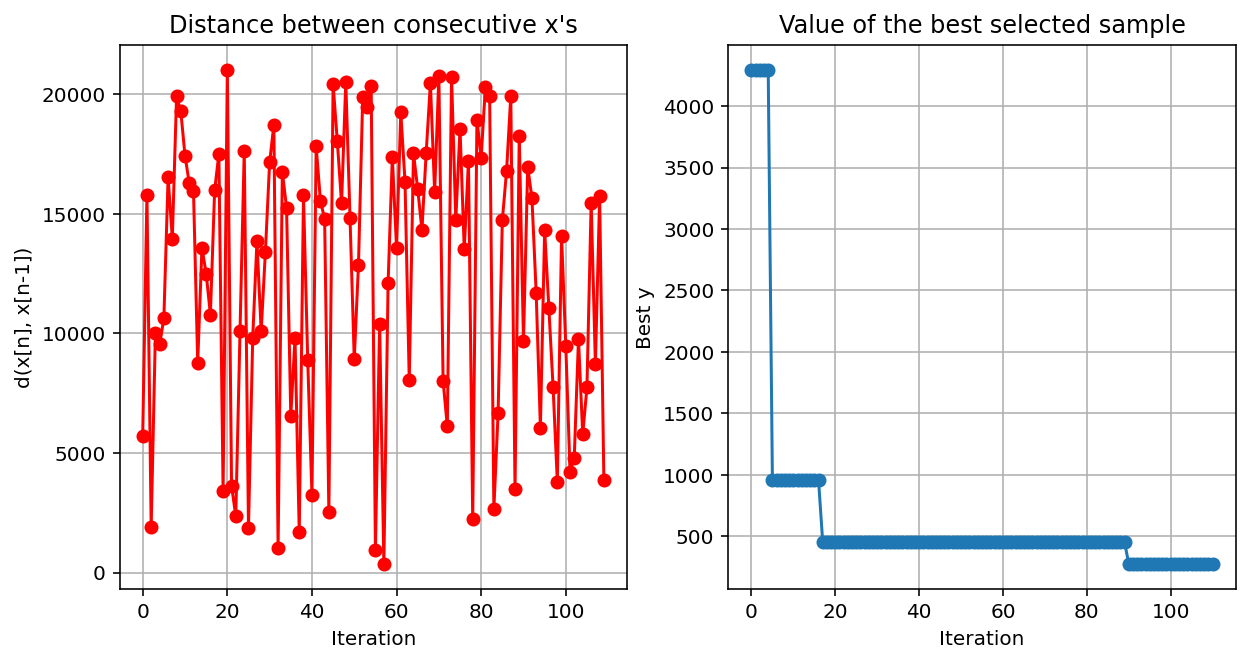

In [10]:
# --- Stop conditions
max_time  = 60.0 * 5  # spend two minutes on the problem 
max_iter  = 100
tolerance = 10    # distance between two consecutive observations 

# Run the optimization                                                  
bo.run_optimization(max_iter = max_iter, 
                    max_time = max_time, 
                    eps = tolerance, 
                    verbosity=False) 

bo.plot_convergence()

## Visualize the Optimal Configuration

In [11]:
# print optimal configuration and objective value
print(bo.x_opt)
print(bo.fx_opt)

[-6.75683564e+03  4.27447047e+03  1.33546722e+00  1.91478911e+02]
274.7456245661644


In [12]:
# view the tuned kernel
k.lengthscale

GP_regression.std_periodic.lengthscale:
Param([2.e+02, 2.e+02, 6.e-02, 4.e+00])

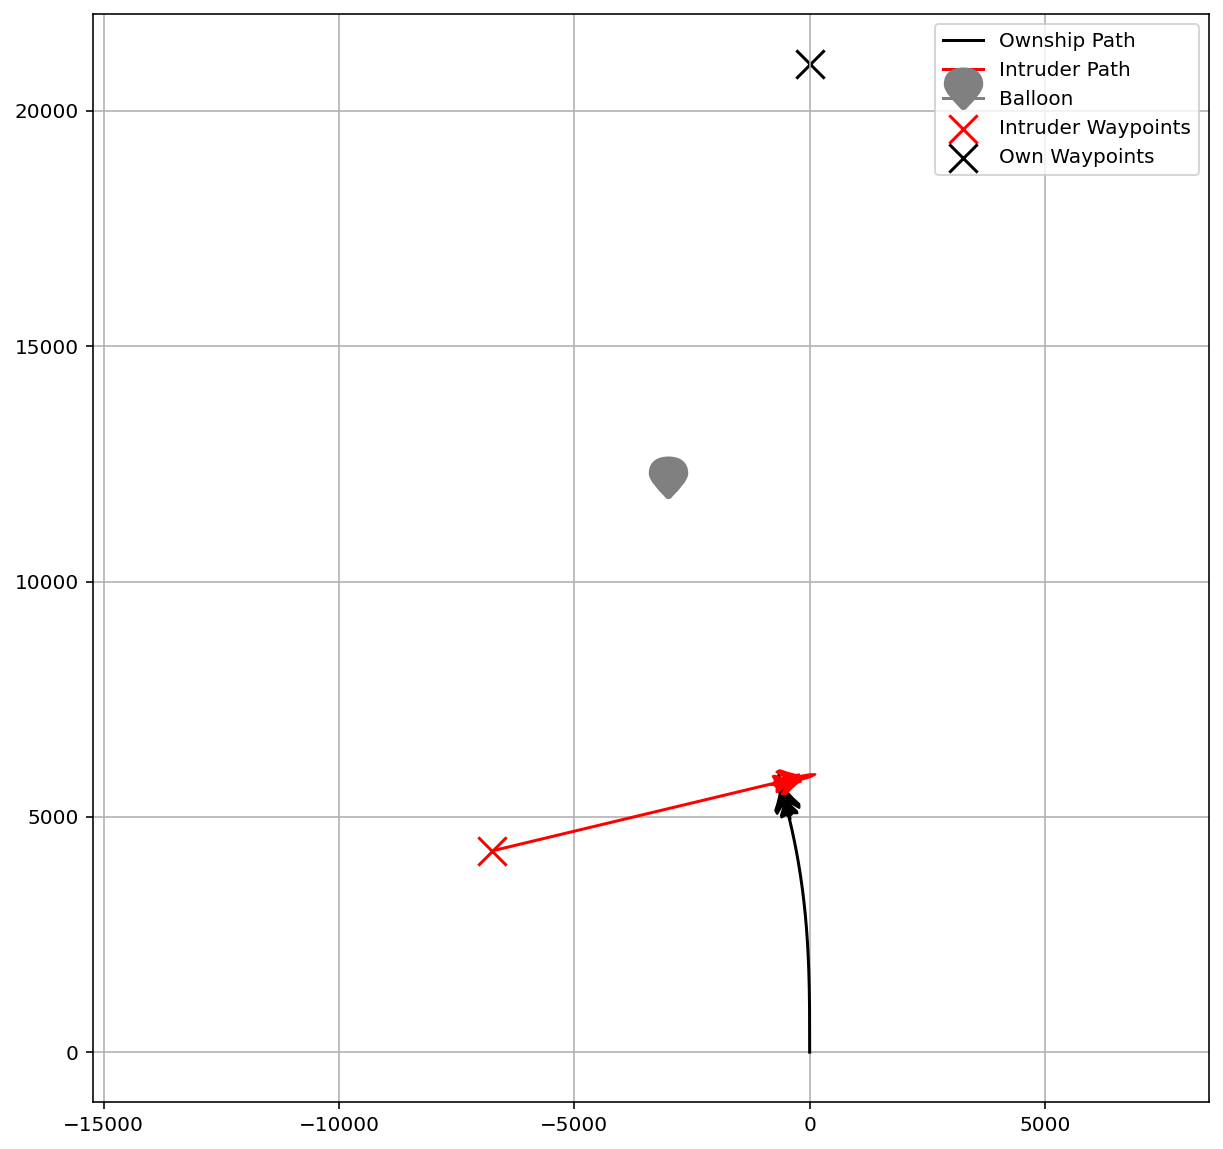

<Figure size 720x720 with 0 Axes>

In [17]:
scen, sys = get_system(bo.x_opt) # relative airspeed
trajs, p = sys.simulate_tspan((0.0, 30.0), return_passed=True, terminating_conditions_all=air_collision_condition)
viewer = AcasScenarioViewer(trajs, scen)
fig, ax = viewer.summary_plot()
plt.show()

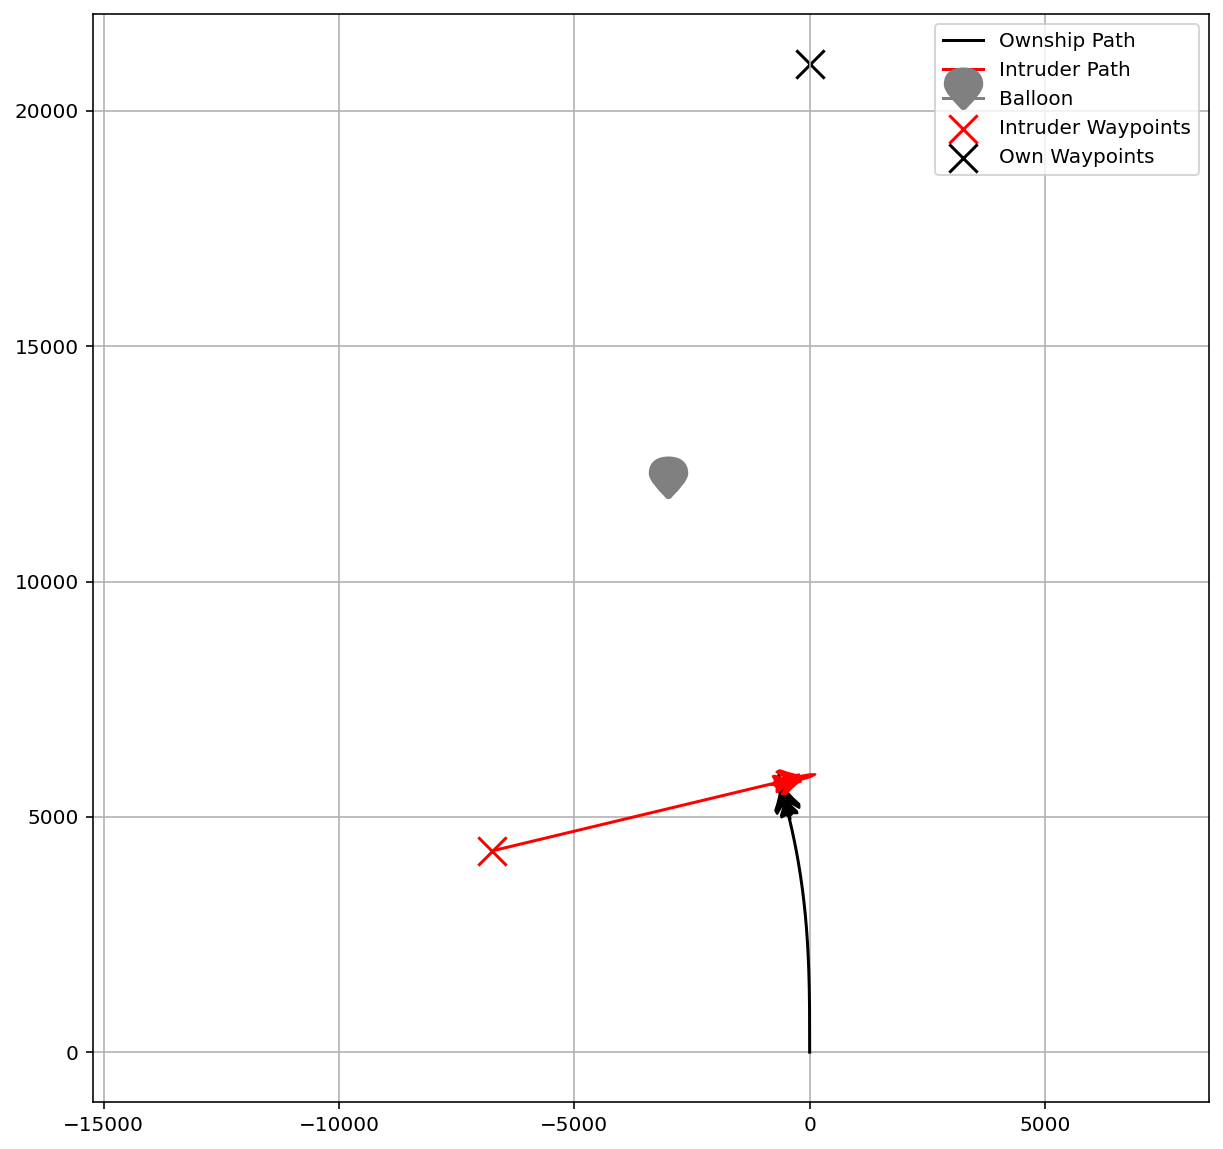

<Figure size 720x720 with 0 Axes>

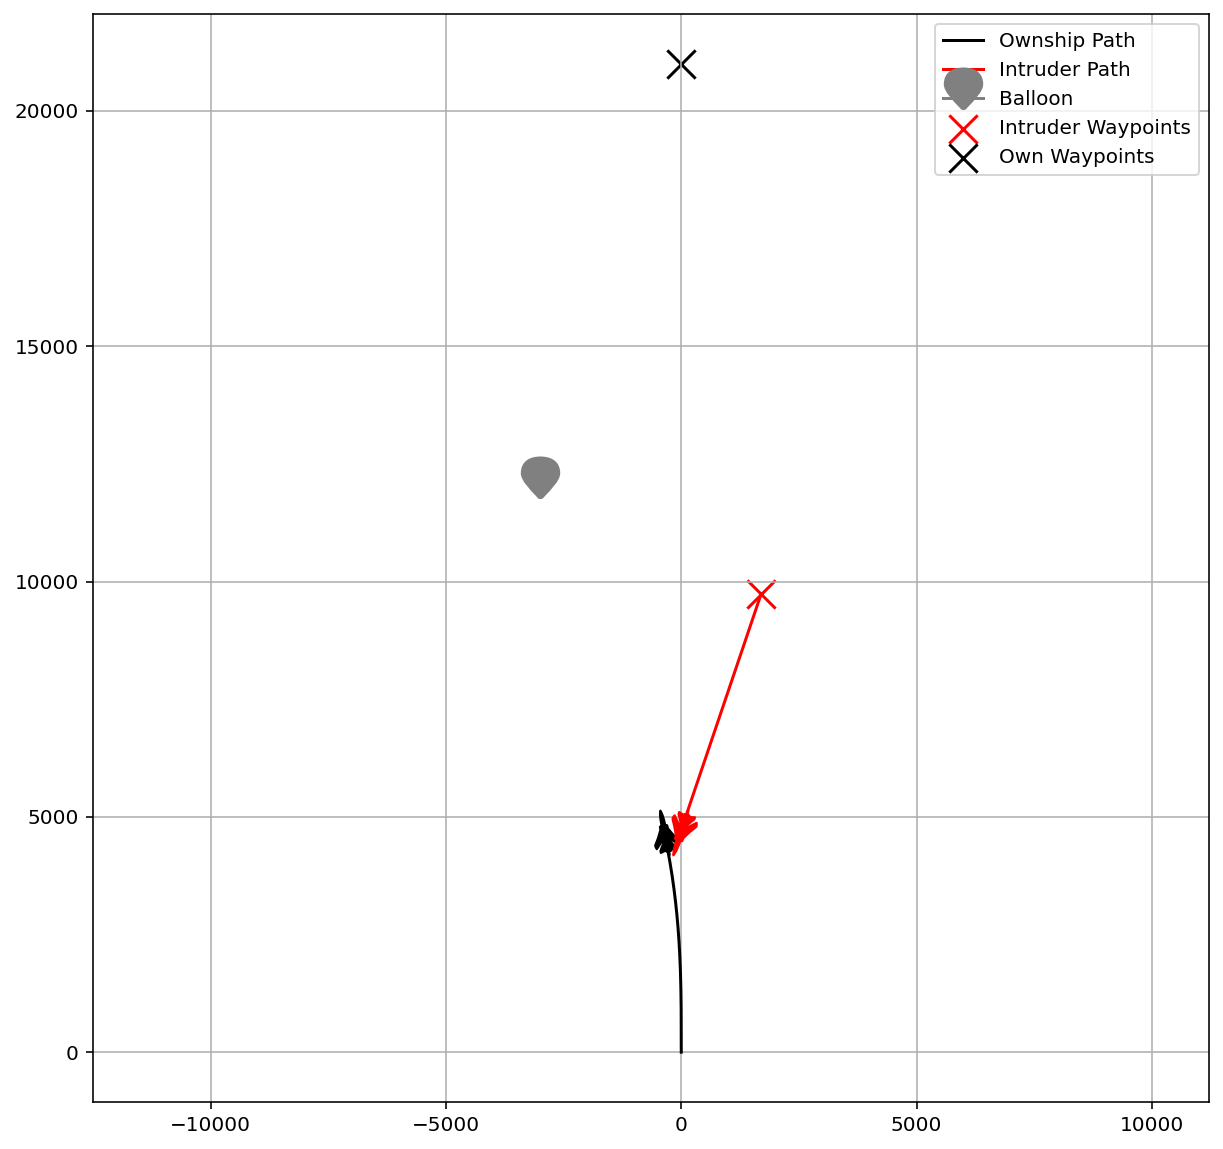

<Figure size 720x720 with 0 Axes>

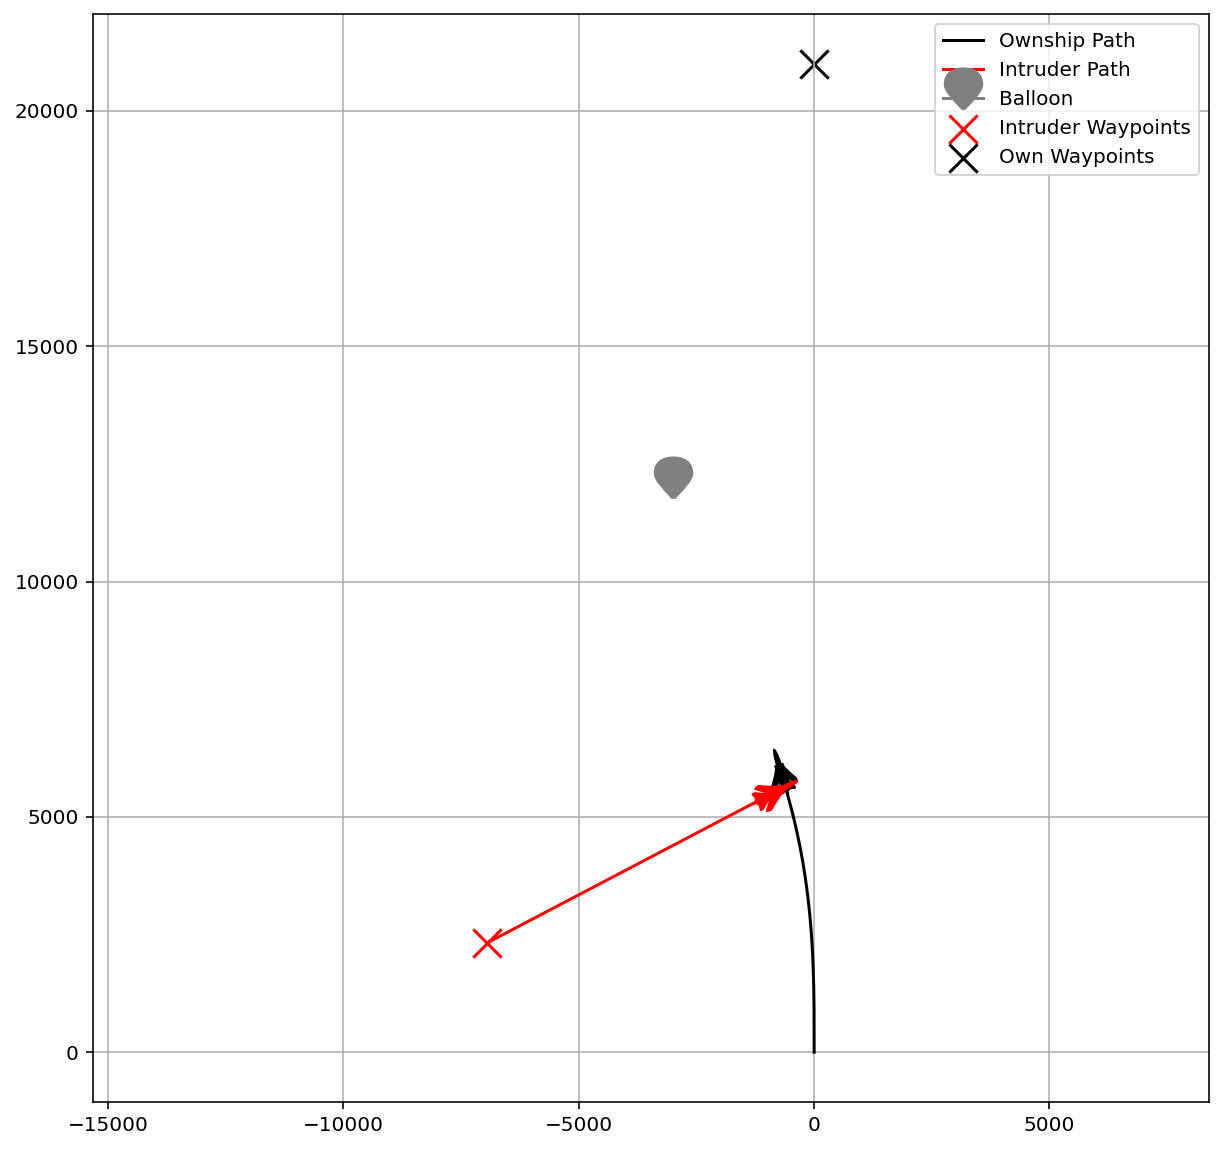

<Figure size 720x720 with 0 Axes>

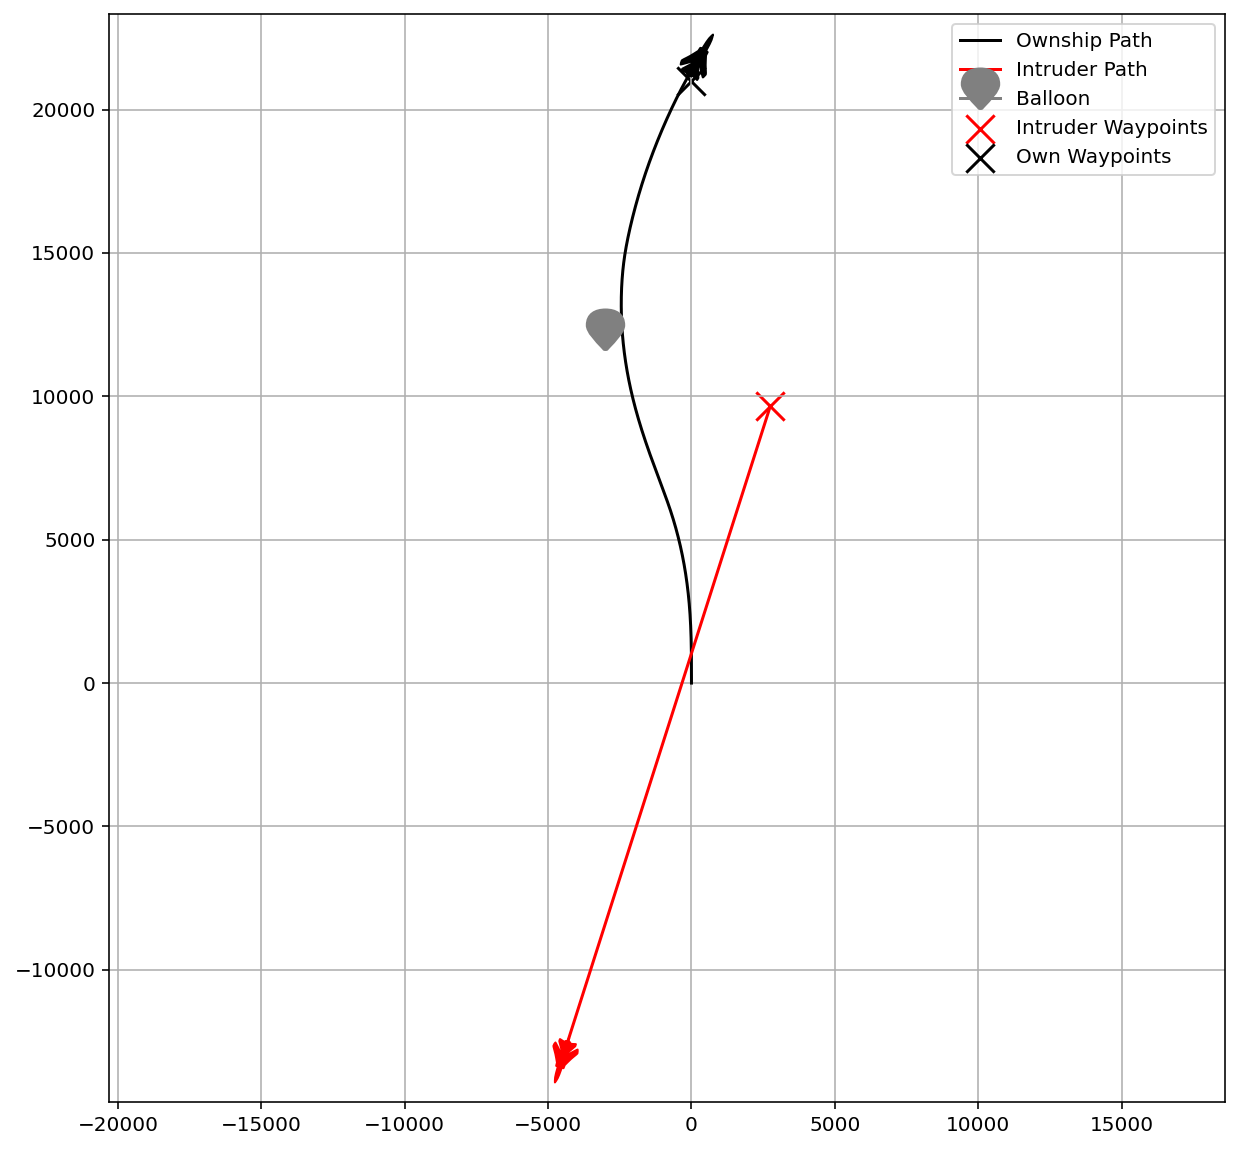

<Figure size 720x720 with 0 Axes>

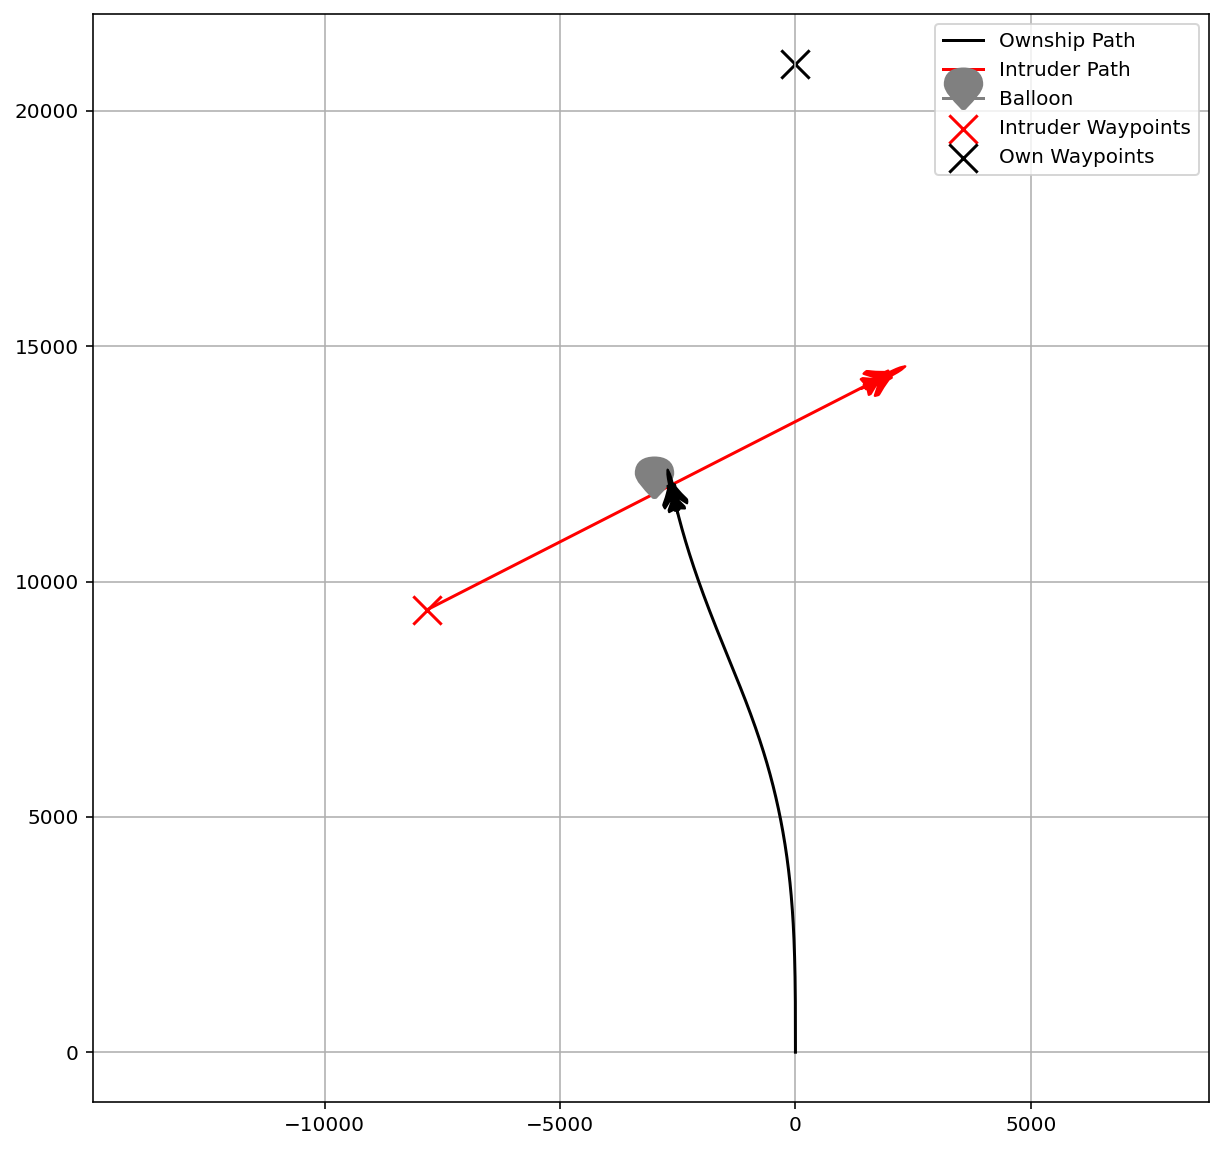

<Figure size 720x720 with 0 Axes>

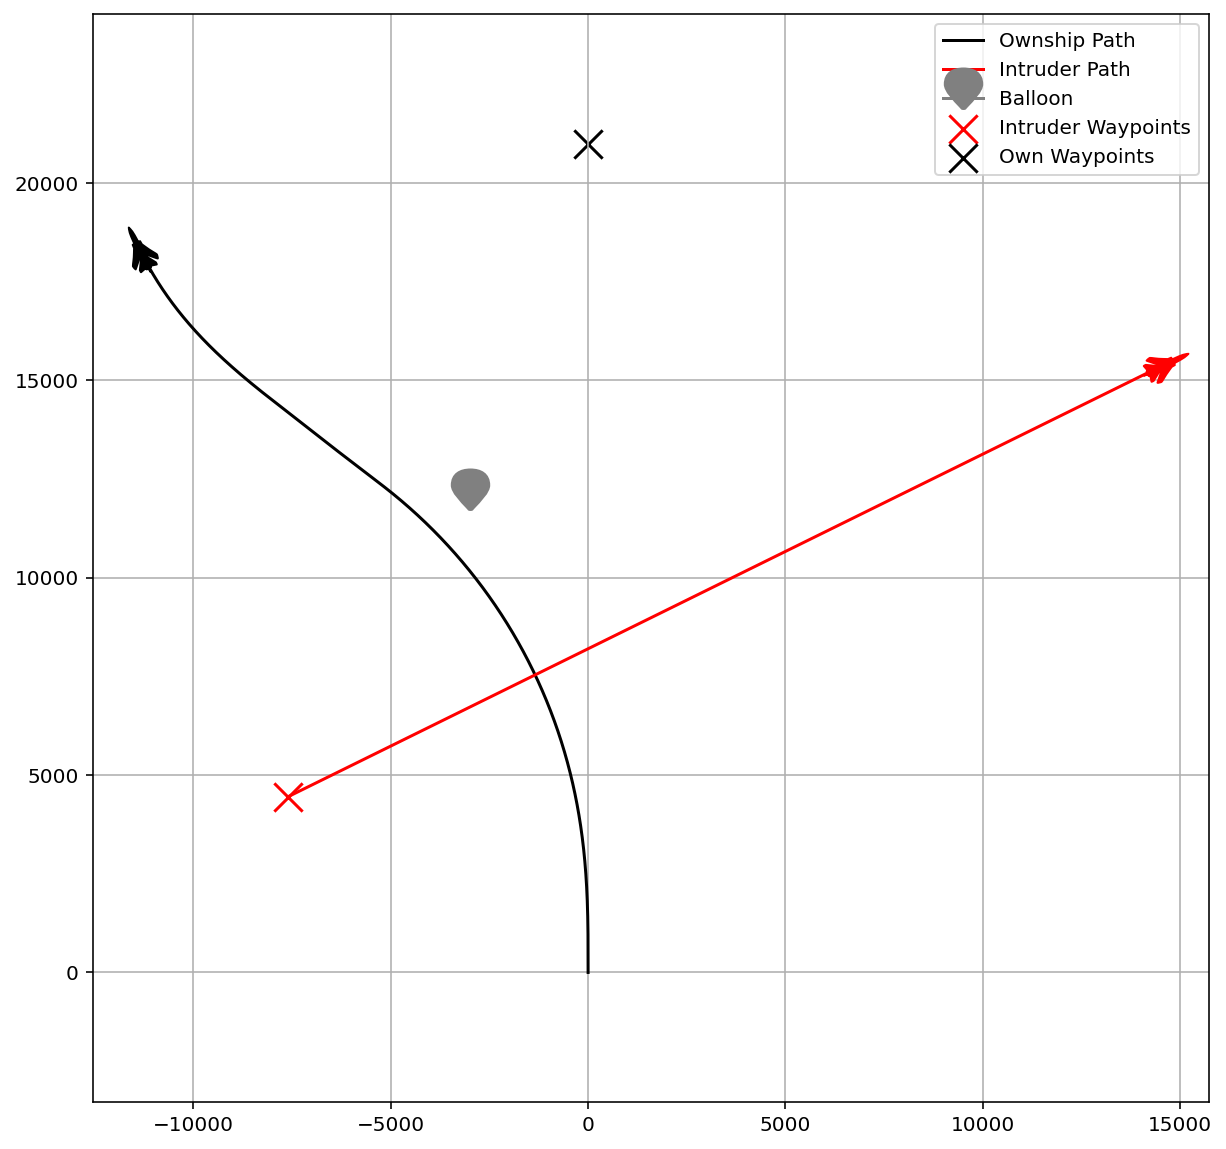

<Figure size 720x720 with 0 Axes>

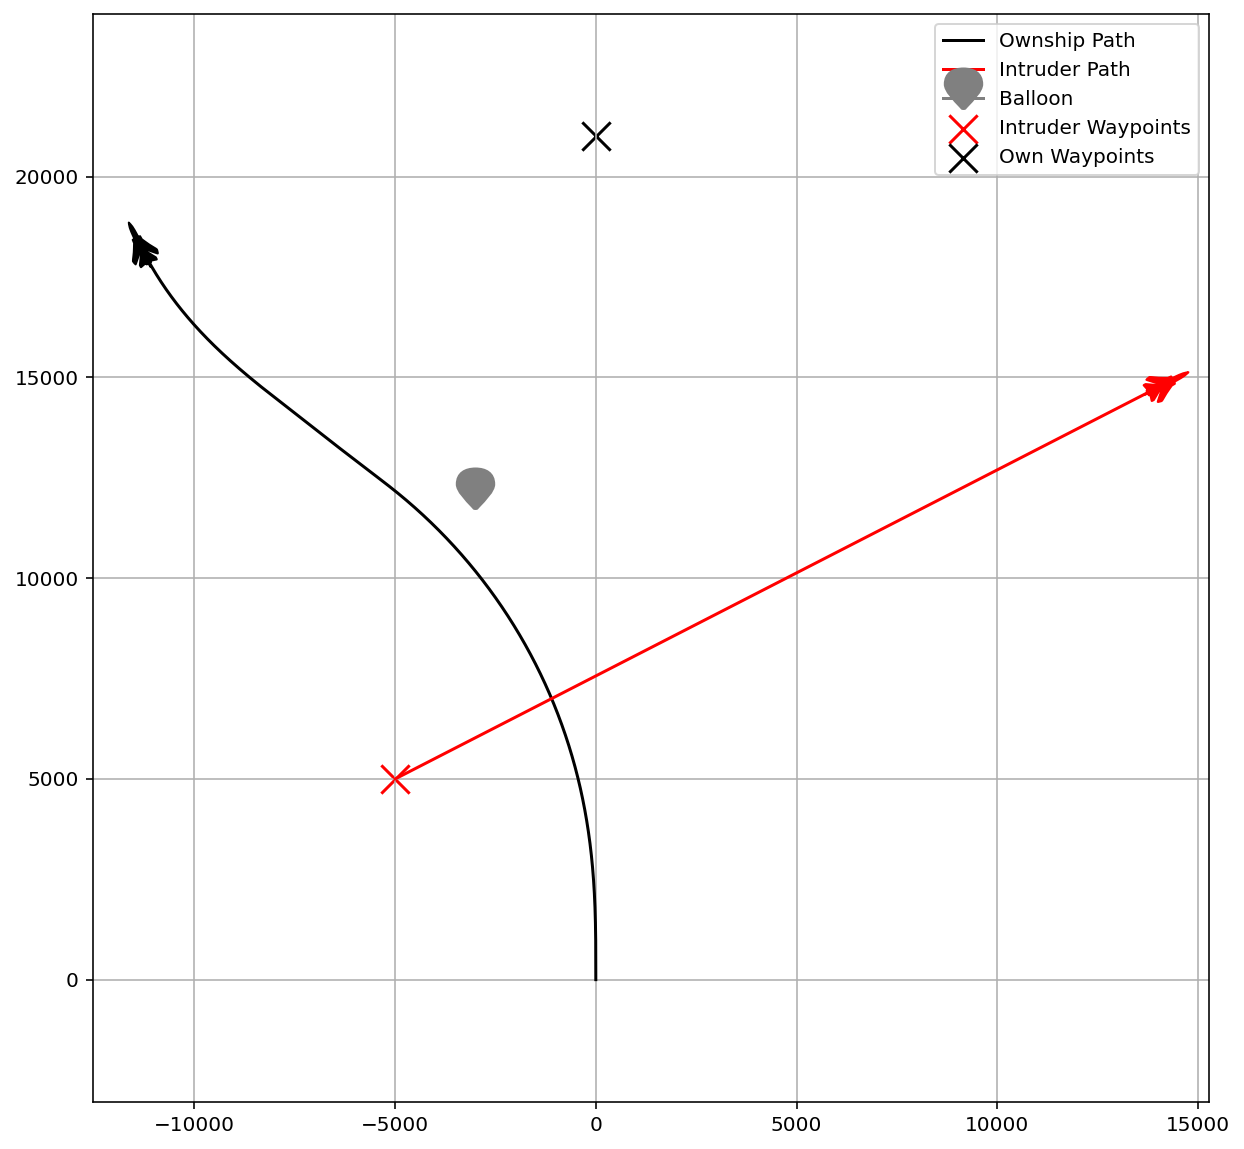

<Figure size 720x720 with 0 Axes>

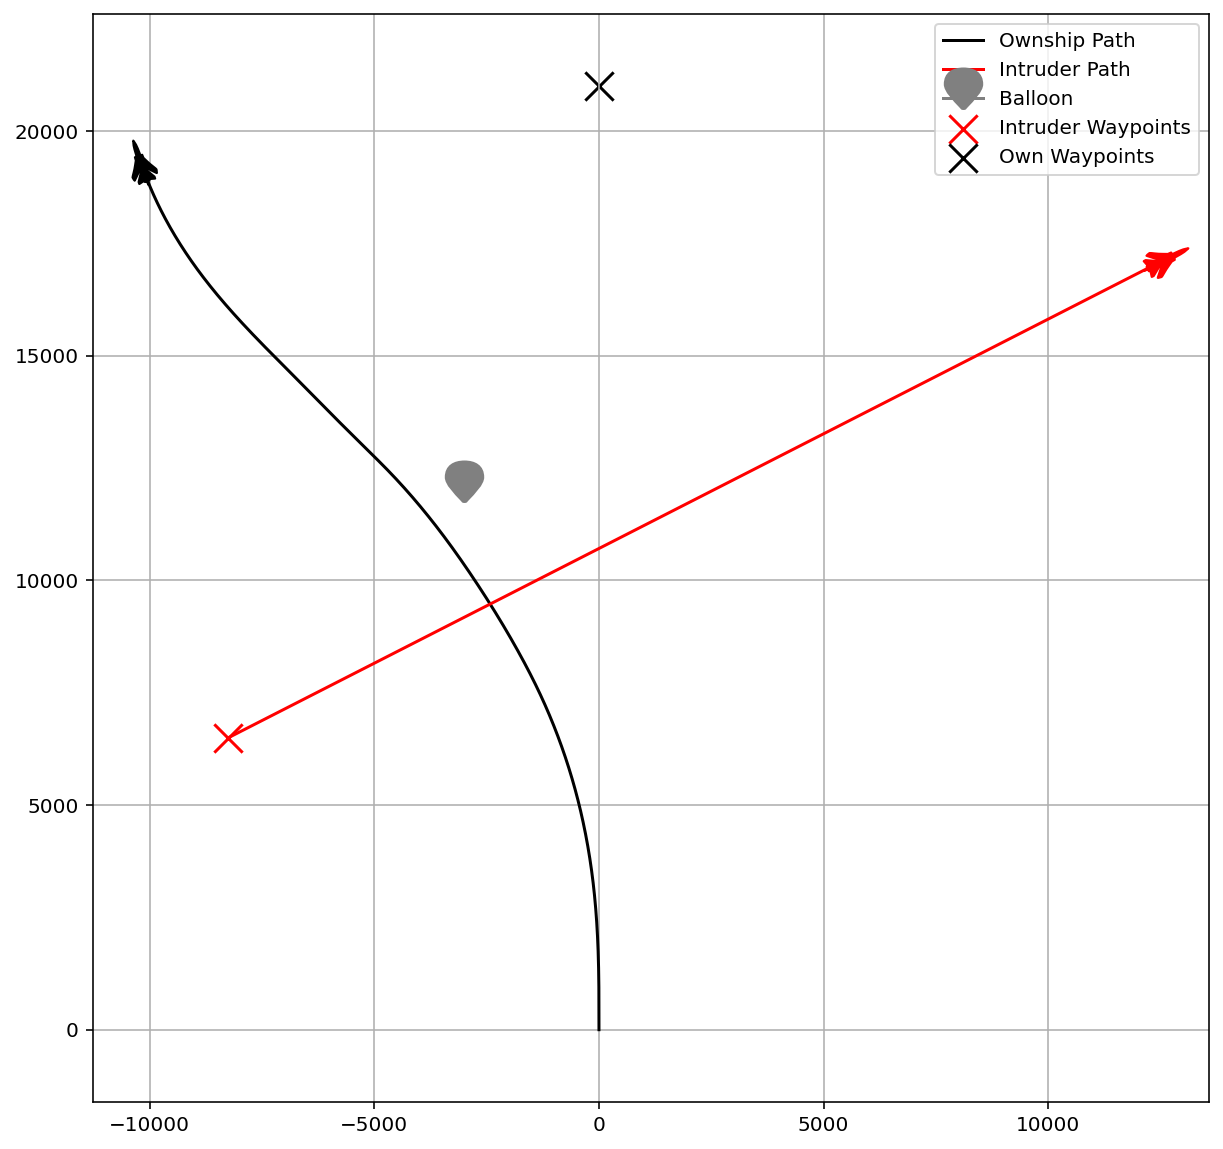

<Figure size 720x720 with 0 Axes>

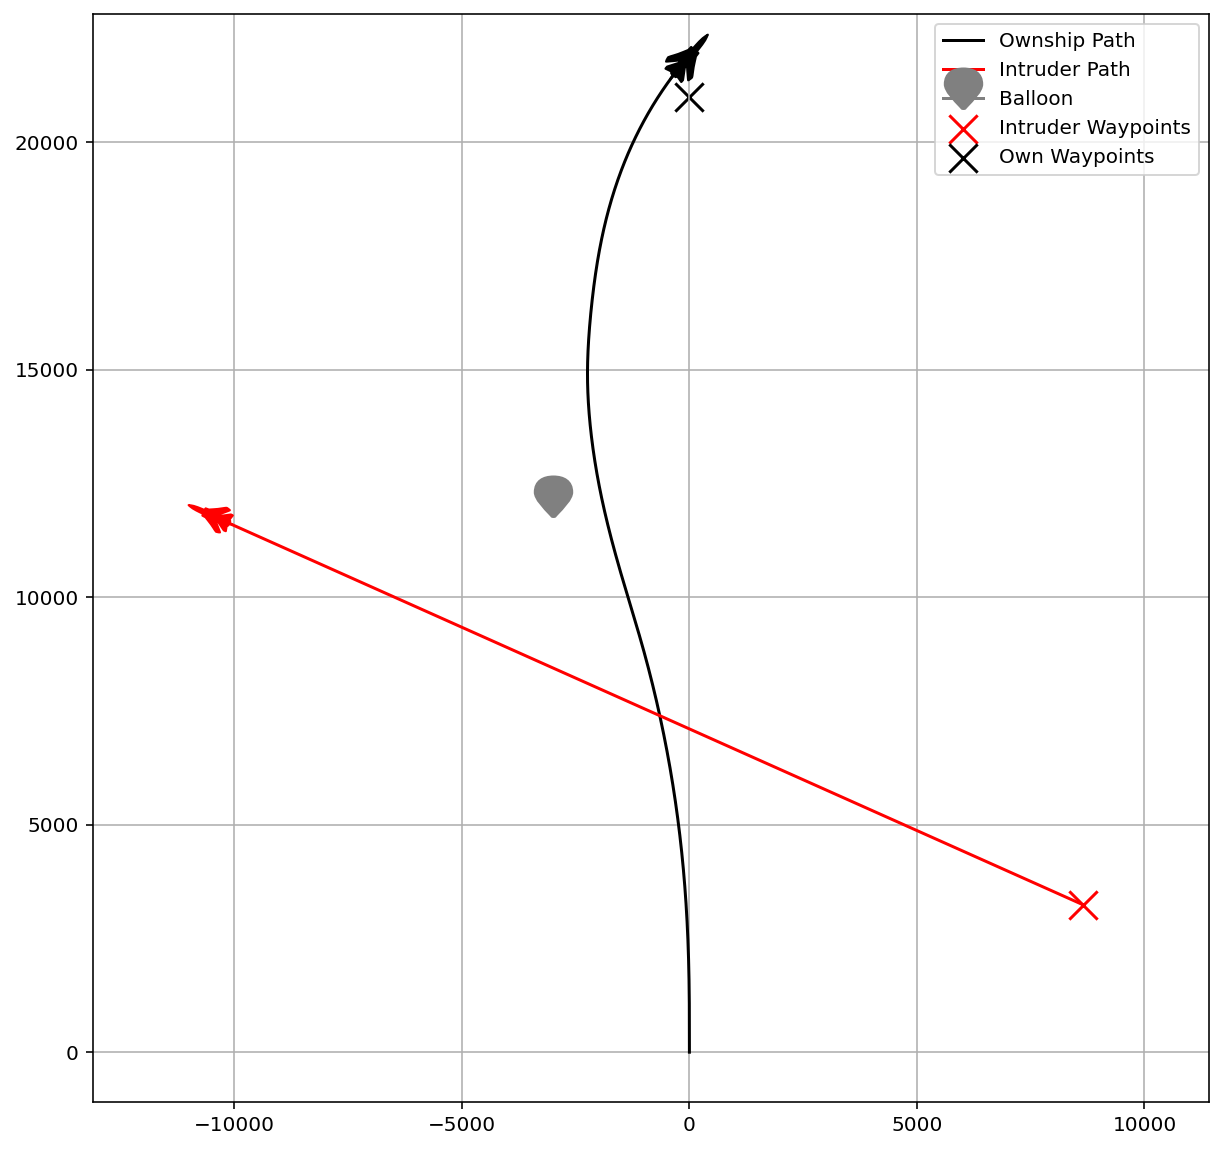

<Figure size 720x720 with 0 Axes>

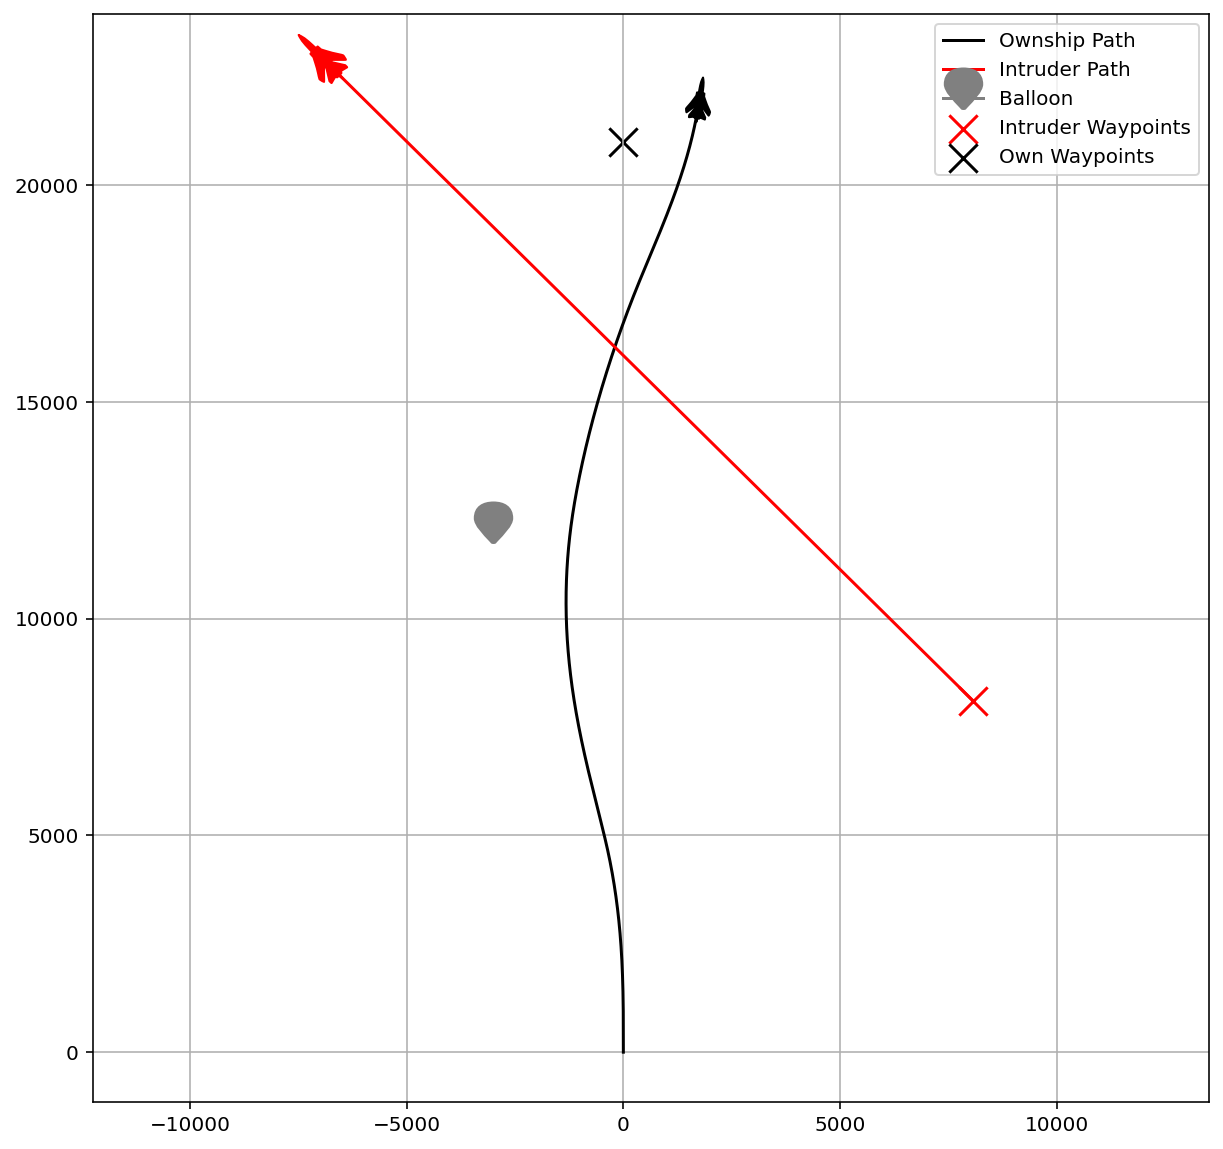

<Figure size 720x720 with 0 Axes>

In [18]:
idxs = np.argsort(bo.Y.flatten())
for idx in idxs[:10]:
    scen, sys = get_system(bo.X[idx]) # relative airspeed
    trajs, p = sys.simulate_tspan((0.0, 30.0), return_passed=True, terminating_conditions_all=air_collision_condition)
    viewer = AcasScenarioViewer(trajs, scen)
    fig, ax = viewer.summary_plot()
    plt.show()

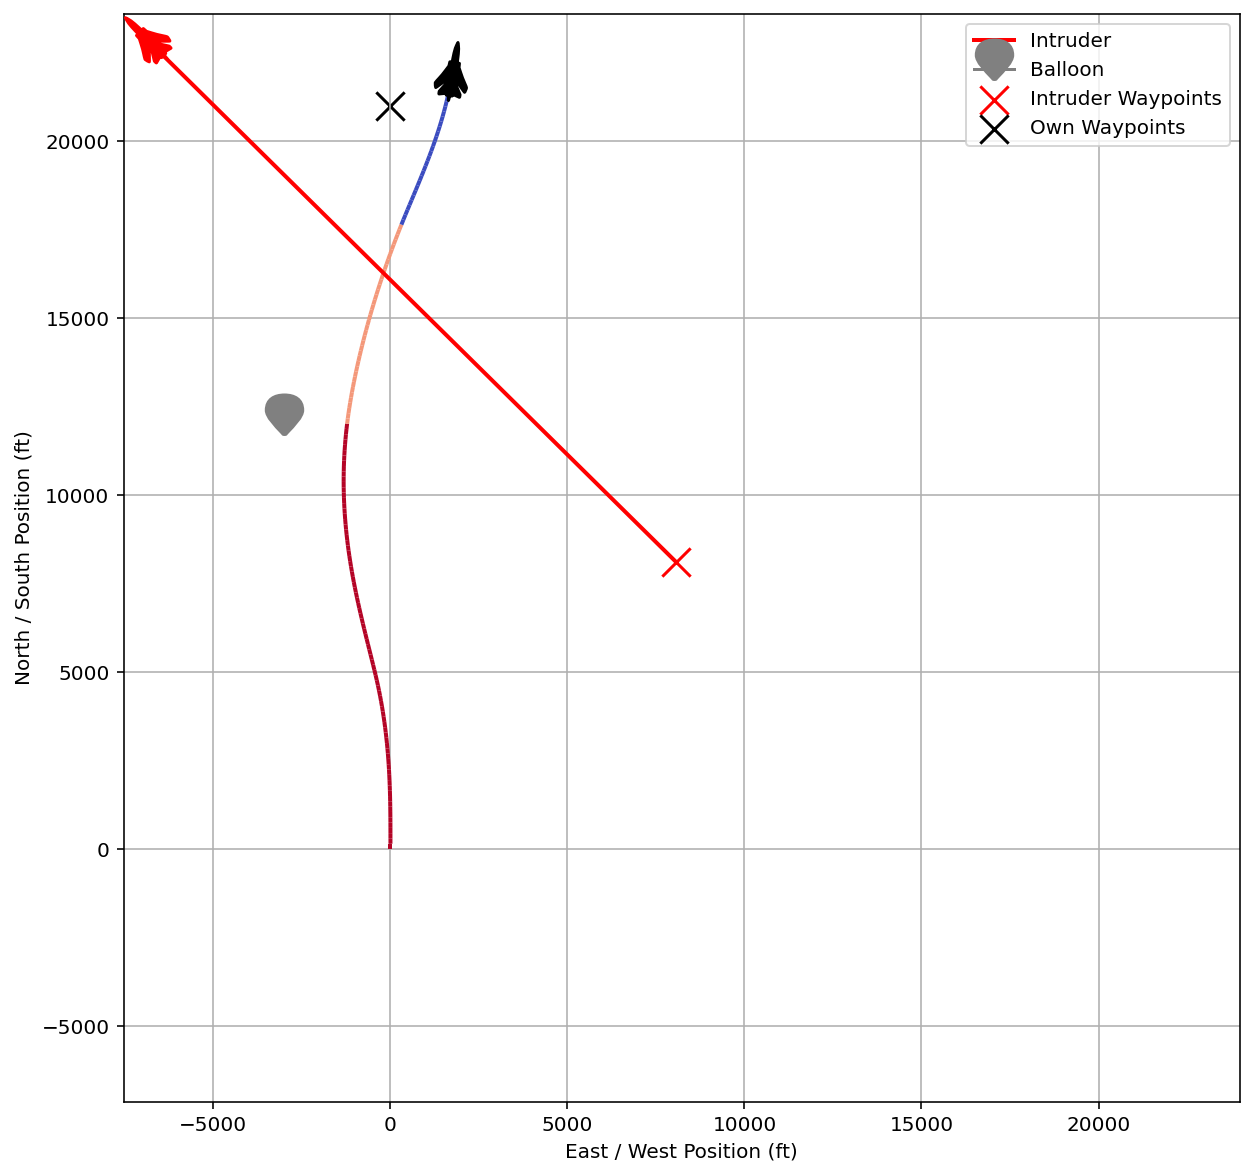

In [15]:
from IPython.display import HTML
from matplotlib import animation
anim = viewer.summary_video()
#writervideo = animation.FFMpegWriter(fps=30) 
#anim.save("bopt_example.mp4", writer=writervideo)
HTML(anim.to_jshtml())

Text(0, 0.5, 'Airspeed (ft/s)')

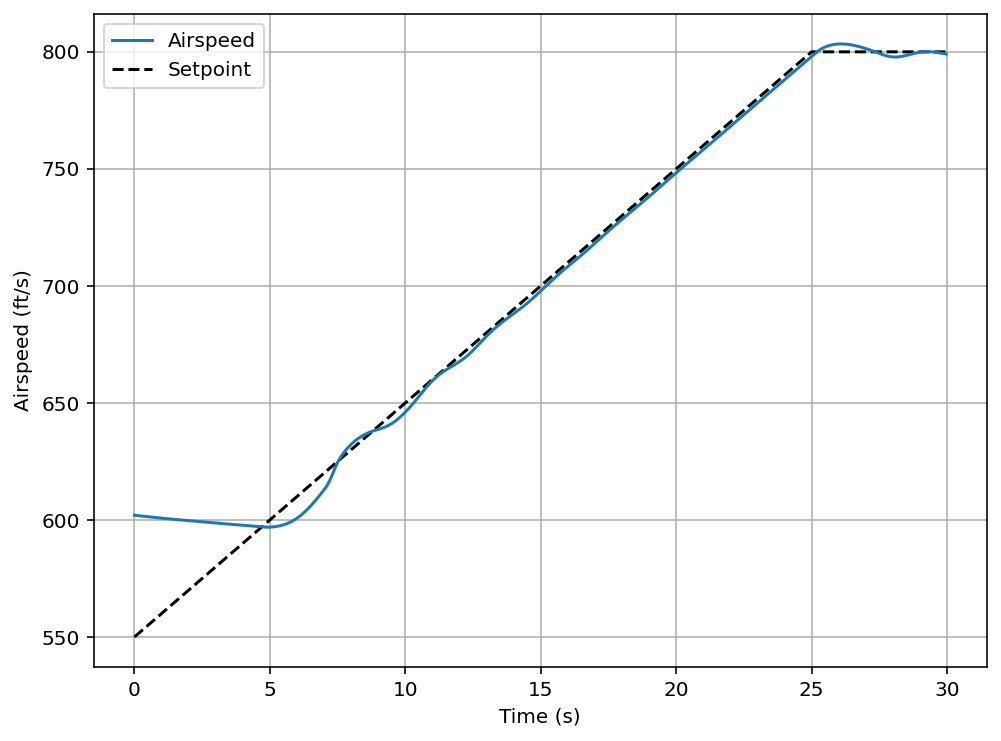

In [32]:
istates = np.array(trajs["intruder_plant"].states)
itimes = np.array(trajs["intruder_plant"].times)

plt.figure(figsize=(8, 6))
plt.plot(itimes, istates[:, 0], zorder=200, label='Airspeed')
plt.plot(itimes, [intruder_airspeed(t) for t in itimes], '--k', label='Setpoint')
plt.grid()
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Airspeed (ft/s)")